In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import interpolate
from scipy import stats
from scipy import signal
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.odr import ODR, Model, Data, RealData
from pylab import *
from openpyxl import Workbook

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker

import os

myfont = {'family': 'sans-serif', 'color':  'black', 'weight': 'normal', 'size': 16,}

In [4]:
data = pd.read_excel(r"EPR Lock-In Data.xlsx",None)
MagResonances = []
FreqResonances = []

In [5]:
def guassDerivative(x,a,b,c,d): # Where a is the height of a guass peak, b is the centre position and c is the s.d.
      return (a*(x-b)*(math.e)**((-((b-x)**2))/(2*c**2)))/(c**2) + d

In [6]:
def lorentzDerivative(x,a,b,c,d):
    return - (a * (1/math.pi) * c * (x-b)) / (((x-b)**2+0.25*c**2)**2) + d

In [7]:
def Linear(x,m,c):
    return m*x+c

[5.246530407709433, 1.220355, 0.3443312896186223, 0]
[5.79198586 1.22205343 0.4072527  6.28606434]
[7.234728109673251, 1.461465, 0.3736360802244622, 0]
[6.69610158 1.45684725 0.40904044 9.73381221]
[6.796544102052926, 1.71738, 0.36630988257300223, 0]
[6.51840865 1.71192806 0.40938509 8.97497483]
[6.283692394749012, 1.97118, 0.36630988257300223, 0]
[5.47826259 1.96873204 0.39636667 8.9311002 ]
[5.567854079163652, 2.172105, 0.40294087083030244, 0]
[4.28115651 2.17953462 0.42239223 7.52102715]
[9.463334901971765, 2.480895, 0.3882884755273825, 0]
[10.63313952  2.47931133  0.43745207  4.66467443]
[17.30791877558851, 2.7346950000000003, 0.4322456614361423, 0]
[16.55770396  2.72945744  0.44334949  5.20117102]
[19.681419349819734, 3.0117599999999998, 0.4395718590876019, 0]
[19.10844982  3.00390352  0.45998877  7.42805225]
[18.440805695307287, 3.2380649999999997, 0.4175932661332231, 0]
[20.08706755  3.24363725  0.46879868  9.66122257]
[21.712427709500034, 3.534165, 0.446898056739063, 0]
[21.388

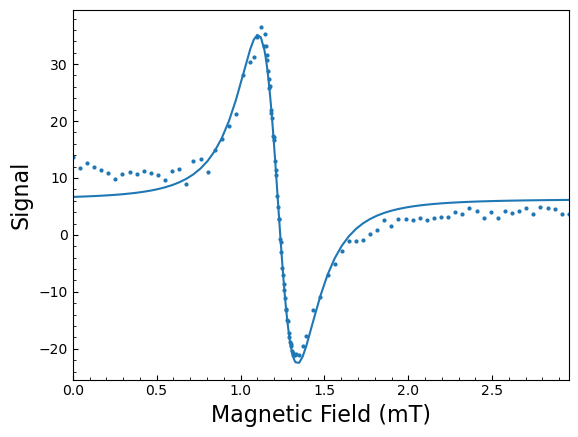

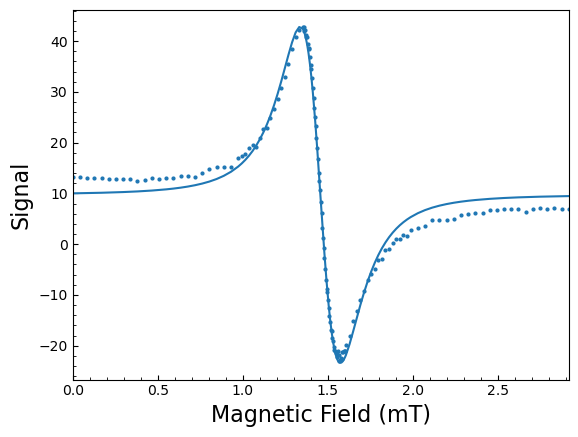

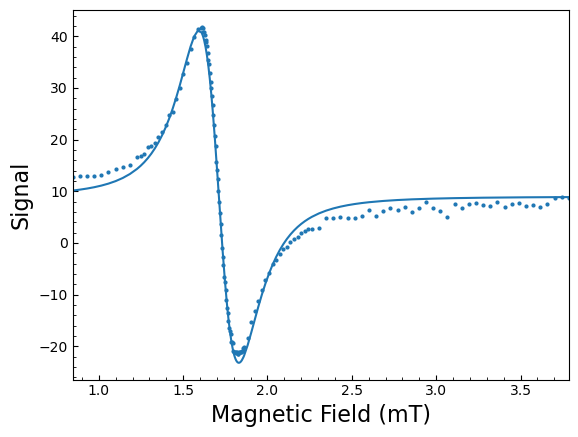

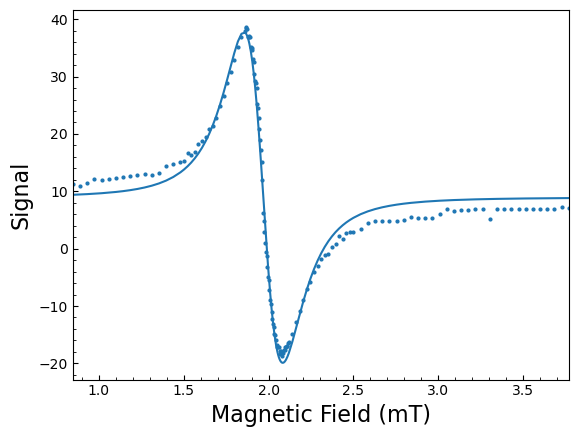

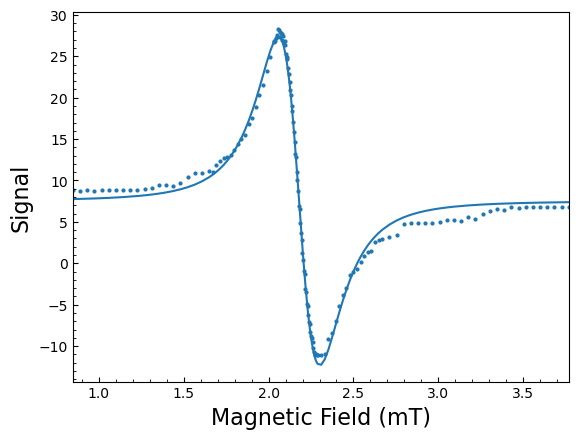

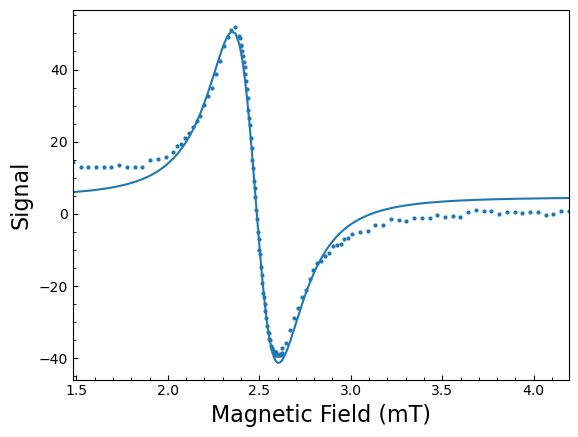

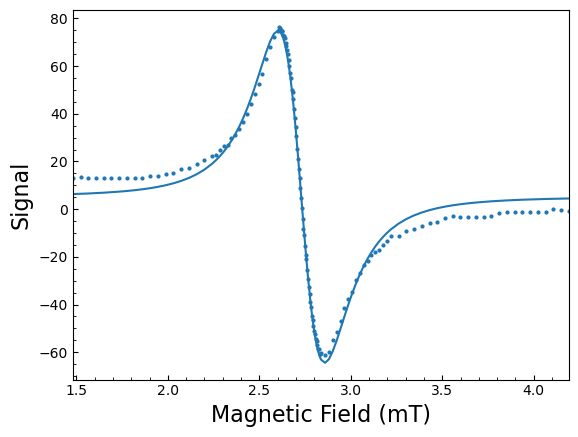

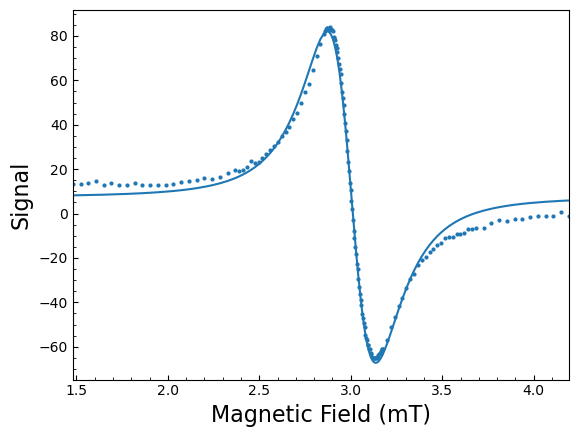

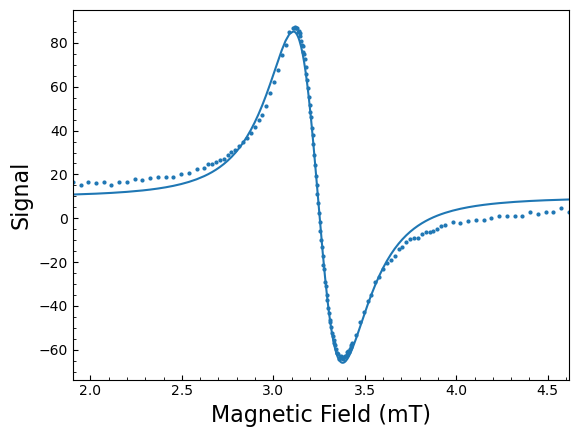

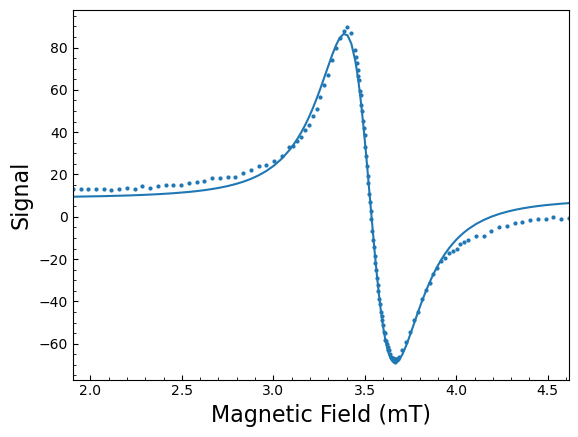

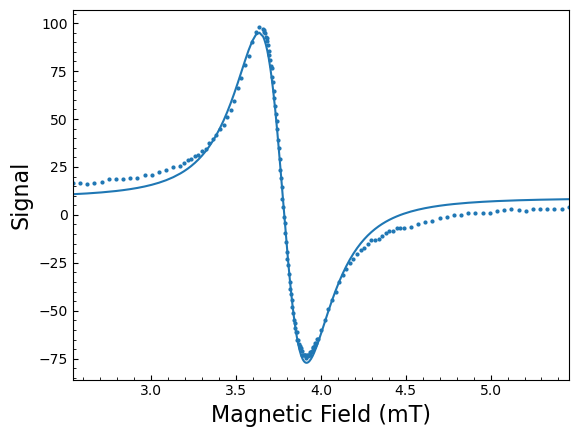

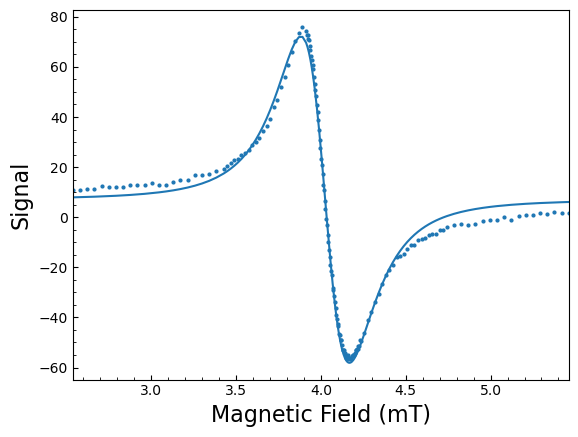

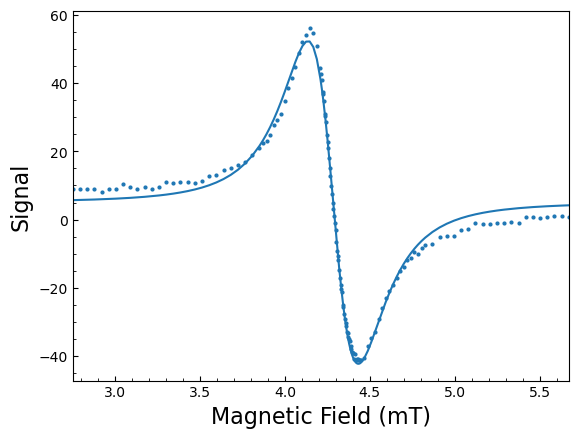

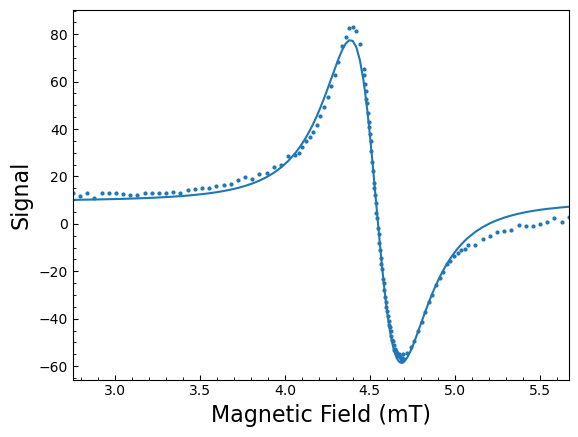

In [9]:
# Resonances Calculations and Graphs
MagResonances = []
FreqResonances = []
threeDData = []
widths = []
amplitudes = []
yOffsets = []
for i, sheet in enumerate(data):


        
        if "test" not in sheet.lower():
            AmpData = (data[sheet]["Amplitude"]).to_numpy()
            MagneticData = (data[sheet]["MagField"]).to_numpy()  

            maxLoc = MagneticData[np.argmax(AmpData)]
            minLoc = MagneticData[np.argmin(AmpData)]
            centre = (minLoc-maxLoc)/2 + maxLoc

            guessGuass =[-(np.max(AmpData)/0.60653)*minLoc-maxLoc,centre, ((minLoc-maxLoc)/2),0]
            guessLorentz = [((np.max(AmpData))*(((minLoc-maxLoc)/2)/0.28869)**2)/0.826,centre, ((minLoc-maxLoc)/2)/0.28869,0]

            print(guessLorentz)

            funcUsed = lorentzDerivative

            popt, pcov = scipy.optimize.curve_fit(funcUsed, MagneticData, AmpData, p0=guessLorentz) 

            print(popt)

            Amp, Loc, SDev,d = popt

            AmpErr,LocErr,SDevErr,dErr = sqrt(diag(pcov))

            widths.append(SDev)
            amplitudes.append(Amp)
            yOffsets.append(d)
            AmpGuess,LocGuess,SDevGuess,d2 = guessLorentz
            signalData = funcUsed(MagneticData,Amp,Loc,SDev,d)
            fig, ax = plt.subplots() 
            ax.plot(MagneticData,signalData)
            ax.scatter(MagneticData,AmpData,s=4)
            ax.set_xlabel("Magnetic Field (mT)",fontdict=myfont)
            ax.set_ylabel("Signal",fontdict=myfont)
            ax.set_xlim(left=MagneticData[0],right = MagneticData[-1])
            ax.tick_params(which='both',direction = 'in')
            ax.minorticks_on()

            plt.savefig(os.path.join(r"Finalised Plots",str(int(float(sheet)*1000)))+"Hz"+".jpg",bbox_inches='tight',dpi=400)

            figData = "Metadata:\n\nAmp: {}±{} \nX offset: {}±{}\nWidth/SDev: {}±{}\nY offset: {}±{}".format(Amp,AmpErr,Loc,LocErr,SDev,SDevErr,d,dErr)
            f = open(os.path.join(r"Finalised Plots",str(int(float(sheet)*1000)))+"Hz"+".txt",'w')
            f.write(figData)
            f.close()
            #plt.show()

            while (MagneticData[-1]<5.6):
                  MagneticData = np.append(MagneticData,(2*MagneticData[-1]-MagneticData[-2]))
                  AmpData = np.append(AmpData,(np.average(AmpData[-5:-1])))
            while (MagneticData[0]>0):
                  MagneticData = np.insert(MagneticData,0,(2*MagneticData[0]-MagneticData[1]))
                  AmpData = np.insert(AmpData,0,(np.average(AmpData[0:4])))


            for magRes,Ampls in zip(MagneticData,AmpData):
                  threeDData.append([magRes,float(sheet),Ampls])
            #plt.xticks(np.linspace(np.min(MagneticData),np.max(MagneticData),10))
            #plt.yticks(np.linspace(np.min(signalData),np.max(signalData),10))


          

            #MagResonances.append((minLoc-maxLoc)/2 + maxLoc)
            MagResonances.append(Loc)
            FreqResonances.append(float(sheet))

            
widths = np.array(widths) *2

print(len(widths))
print(len(amplitudes))


2.612967278086122e-29


TypeError: Colorbar.__init__() got an unexpected keyword argument 'fontdict'

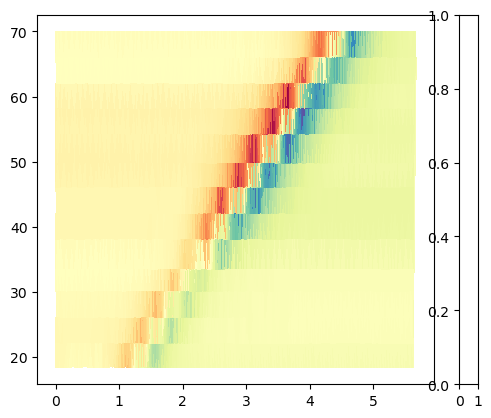

In [12]:
# 3D code Plot




xData = []
yData = []
zData = []
for element in threeDData:
    xData.append(element[0])
    yData.append(element[1])
    zData.append(element[2])

xData = np.array(xData)
yData = np.array(yData)
zData = np.array(zData)

plot1,ax = plt.subplots()

guessLinear = [12,0]

popt, pcov = scipy.optimize.curve_fit(Linear, MagResonances, FreqResonances, p0=guessLinear)

grad,yInt = popt

gradU,yIntU = sqrt(diag(pcov))

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(MagResonances, FreqResonances)
print(p_value)
cmaps = ax.tripcolor(xData,yData,zData,cmap="Spectral_r",zorder = 1)
cbarsz = plot1.colorbar(cmaps,label = "Signal")
cbarsz.ax.set_label(fontdict = myfont)
ax.set_xlabel("Magnetic Field (mT)",fontdict=myfont)
ax.set_ylabel("Frequency (MHz)",fontdict=myfont)

ax.plot(MagResonances,grad*np.array(MagResonances)+yInt,zorder = 2,c="green")
ax.set_xlim(np.min(xData),np.max(xData))
ax.set_ylim(np.min(yData),np.max(yData))
ax.tick_params(which="both",direction= "in")
ax.minorticks_on()

ax.scatter(MagResonances,FreqResonances,s=6,c='black',zorder = 3)

plt.savefig(os.path.join(r"Finalised Plots","3D Graph - New"+".jpg"),bbox_inches='tight',dpi=1000)

figData = "Metadata:\n\nGrad Line: {}±{} \nY offset: {}±{}\nR squared Val: {}".format(grad,gradU,yInt,yIntU,r_value**2)
f = open(os.path.join(r"Finalised Plots","ColorPlot Metadata"+".txt"),'w')
f.write(figData)
f.close()
plt.show()

0.9512406502037112


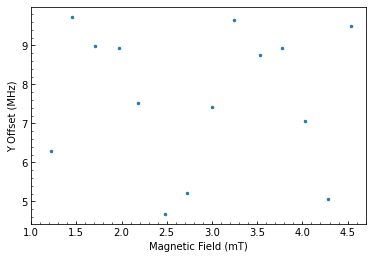

In [8]:
# Y offsets Analysis
plot2,ax2 = plt.subplots()

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(MagResonances, yOffsets)

print(p_value)

ax2.scatter(MagResonances,yOffsets,s=6)
ax2.set_xlabel("Magnetic Field (mT)")
ax2.set_ylabel("Y Offset (MHz)")
ax2.tick_params(which="both",direction= "in")
ax2.minorticks_on()
ax2.set_xlim(left=1)

plt.savefig(os.path.join(r"C:\Users\matth\Documents\Phys 382\Lock-In data\Finalised Plots","YOffsets"+".jpg"),bbox_inches='tight',dpi=400)

plt.show()

0.0754491253123897


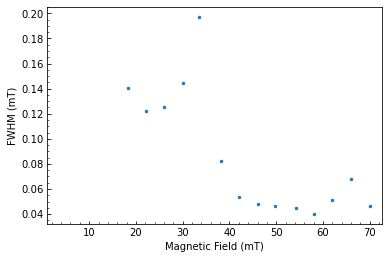

In [25]:
# widths analysis
plot2,ax2 = plt.subplots()



slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(MagResonances, widths)

print(slope)

ax2.scatter(FreqResonances,np.divide(widths,amplitudes),s=6)
ax2.set_xlabel("Magnetic Field (mT)")
ax2.set_ylabel("FWHM (mT)")
ax2.tick_params(which="both",direction= "in")
ax2.minorticks_on()
ax2.set_xlim(left=1)

plt.savefig(os.path.join(r"C:\Users\matth\Documents\Phys 382\Lock-In data\Finalised Plots","Widths"+".jpg"),bbox_inches='tight',dpi=400)

plt.show()

In [10]:
# Varying Modulation Data Reading

data = pd.read_excel(r"C:\Users\matth\Documents\Phys 382\Lock-In data\EPR Lock-In Data - Vary Amp Freq.xlsx",None)


0.007921080921937185
0.004868654420351521


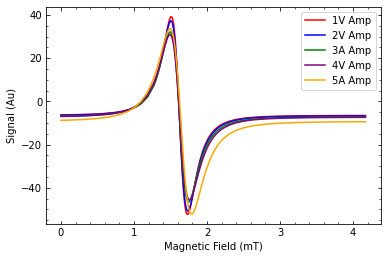

In [11]:

plot,ax = plt.subplots()
counter1 = 0
counter2 = 0

widths = []

colorset = ["red","blue","green","purple","orange","black","yellow"]

for i,sheet in enumerate(data):
    MagFields = data[sheet]["MagField"].to_numpy()
    SignalAmps = data[sheet]["Amplitude"].to_numpy()

    if (sheet[0] == '2'):
        SignalAmps = SignalAmps*0.5
    if (sheet[0] == '3'):
        SignalAmps = SignalAmps*0.33333333333333333

    #ax.scatter(MagFields,SignalAmps,s=4,c=colorset[i])

    ax.tick_params(which="both",direction= "in",top=True,right=True)
    ax.minorticks_on()  
    ax.set_xlabel("Magnetic Field (mT)")
    ax.set_ylabel("Signal (Au)")

    maxLoc = MagFields[np.argmax(SignalAmps)]
    minLoc = MagFields[np.argmin(SignalAmps)]
    centre = (minLoc-maxLoc)/2 + maxLoc

    guessGuass =[-(np.max(SignalAmps)/0.60653)*minLoc-maxLoc,centre, ((minLoc-maxLoc)/2),0]
    guessLorentz = [((np.max(SignalAmps))*(((minLoc-maxLoc)/2)/0.28869)**2)/0.826,centre, ((minLoc-maxLoc)/2)/0.28869,0]



    funcUsed = lorentzDerivative

    popt, pcov = scipy.optimize.curve_fit(funcUsed, MagFields, SignalAmps, p0=guessLorentz) 

    widths.append(popt[1])

    Amp, Loc, SDev,d = popt

    AmpErr,LocErr,SDevErr,dErr = sqrt(diag(pcov))

    signalData = funcUsed(MagFields,Amp,Loc,SDev,d)

    line, = ax.plot(MagFields,signalData,c=colorset[i])
    line.set_label(sheet)

widths = np.array(widths)

print(np.std(widths))
print(np.std(widths)/np.average(widths))

ax.legend()

plt.savefig(os.path.join(r"C:\Users\matth\Documents\Phys 382\Lock-In data\Finalised Plots","Varying Amps"+".jpg"),bbox_inches='tight',dpi=400)

plt.show()

[2391.5979462222012, 2.3688, 8.205341369635248, 0]


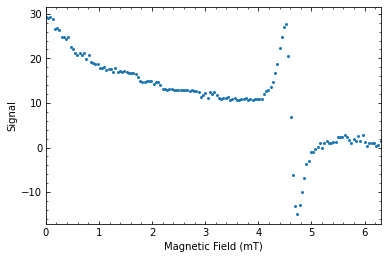

In [12]:
# High Frequency - Poor Result Plot



PoorDat = pd.read_excel(r"C:\Users\matth\Downloads\EPR Lock-In Data (2).xlsx",None)

AmpData = (PoorDat["72.2"]["Amplitude"]).to_numpy()
MagneticData = (PoorDat["72.2"]["MagField"]).to_numpy()  

maxLoc = MagneticData[np.argmax(AmpData)]
minLoc = MagneticData[np.argmin(AmpData)]
centre = (minLoc-maxLoc)/2 + maxLoc

guessGuass =[-(np.max(AmpData)/0.60653)*minLoc-maxLoc,centre, ((minLoc-maxLoc)/2),0]
guessLorentz = [((np.max(AmpData))*(((minLoc-maxLoc)/2)/0.28869)**2)/0.826,centre, ((minLoc-maxLoc)/2)/0.28869,0]

print(guessLorentz)

funcUsed = lorentzDerivative

#popt, pcov = scipy.optimize.curve_fit(funcUsed, MagneticData, AmpData, p0=guessLorentz) 

#print(popt)

#Amp, Loc, SDev,d = popt

#AmpErr,LocErr,SDevErr,dErr = sqrt(diag(pcov))

#AmpGuess,LocGuess,SDevGuess,d2 = guessLorentz
#signalData = funcUsed(MagneticData,Amp,Loc,SDev,d)
fig, ax = plt.subplots() 
#ax.plot(MagneticData,signalData)
ax.scatter(MagneticData,AmpData,s=4)
ax.set_xlabel("Magnetic Field (mT)")
ax.set_ylabel("Signal")
ax.set_xlim(left=MagneticData[0],right = MagneticData[-1])
ax.tick_params(which='both',direction = 'in',top=True,right=True)
ax.minorticks_on()
plt.savefig(os.path.join(r"C:\Users\matth\Documents\Phys 382\Lock-In data\Finalised Plots",str(int(float("72.2")*1000)))+" High Freq Error "+"Hz"+".jpg",bbox_inches='tight',dpi=400)

plt.show()

figData = "Metadata:\n\nAmp: {}±{} \nX offset: {}±{}\nWidth/SDev: {}±{}\nY offset: {}±{}".format(Amp,AmpErr,Loc,LocErr,SDev,SDevErr,d,dErr)
f = open(os.path.join(r"C:\Users\matth\Documents\Phys 382\Lock-In data\Finalised Plots",str(int(float("72.2")*1000)))+" High Freq Error "+"Hz"+".txt",'w')
f.write(figData)
f.close()